In [1]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric
import numpy as np
from torch_geometric.datasets import CoraFull, CitationFull
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import seaborn as sns

from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import ToUndirected
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.transforms import ToUndirected
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal


%config InlineBackend.figure_format = 'retina'
sns.set()


In [2]:
ADJ_PATH = '/home/udit/Documents/Progyan/results_new_95/Year_{}.npy'
COORD_PATH = '/home/udit/Documents/Progyan/Lat_lon/lat_lon-{}.csv'

In [3]:
graph_list = []

for year in tqdm(range(2003, 2018)):
    if year == 2005 or year == 2012:
        continue
    i = year
    adj_matrix = np.load(ADJ_PATH.format(i))
    lat_lon_df = pd.read_csv(COORD_PATH.format(i))

    adj_matrix = adj_matrix + adj_matrix.transpose()
    ##### REMOVE ######
    adj_matrix = adj_matrix[:4523, :4523]
    ###################
    adj_matrix[adj_matrix  < 0.3] = 0
    np.fill_diagonal(adj_matrix, 0)
    G = nx.from_numpy_matrix(adj_matrix)

    lat_lon_dict = {}
    for i in range(len(lat_lon_df)):
        lat_lon_dict[i] = [lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'], lat_lon_df.loc[i, 'rain']]

    nx.set_node_attributes(G, lat_lon_dict, 'pos')
    pos = nx.get_node_attributes(G, 'pos')

    central_nodes = []

    for n in G.nodes:
        if G.nodes[n]['pos'][0] > 74.5 and G.nodes[n]['pos'][0] < 86.5 and G.nodes[n]['pos'][1] > 16.5 and G.nodes[n]['pos'][1] < 26.5:
            central_nodes.append(n)

    G = G.subgraph(central_nodes)

    graph_list.append(G)

100%|██████████| 15/15 [00:51<00:00,  3.41s/it]


In [4]:
for _, G in tqdm(enumerate(graph_list)):        
    plot = plt.figure(figsize=(10,10))
    india_coords = [[67, 97], [5.5, 38]]
    india_pos = {}

    for node_id, coords in pos.items():
        if coords[1] > 5.5 and coords[1] < 38 and coords[0] > 67 and coords[0] < 97:
            india_pos[node_id] = coords

    d = dict(G.degree)
    degree_dict = dict(G.degree()) 
    degree_values = np.array(list(degree_dict.values())) 

    cmap = plt.cm.get_cmap('tab20')
    cmap_edge = plt.cm.get_cmap('tab20')

    normalized_degrees = (degree_values - degree_values.min()) / (degree_values.max() - degree_values.min())

    node_colors = cmap(normalized_degrees)

    edge_widths = [d['weight'] for (u, v, d) in G.edges(data=True)]
    edge_colors = [d['weight']**3 for (u, v, d) in G.edges(data=True)]

    edge_colors = cmap_edge(edge_colors)

    ################ PLOT NETWORK #####################
    # nx.draw_networkx(G, pos = india_pos,
    #         nodelist=d, 
    #         width=edge_widths,
    #         edge_color=edge_colors,
    #         edgecolors = 'black',
    #         node_size=[(d[k])**1.5 for k in d],
    #         with_labels = False,
    #         node_color=node_colors,)
            
    # img = plt.imread('/home/udit/Documents/Progyan/GNN/physical-map-india.jpg')
    # plt.imshow(img, extent=[68, 96.5, 5.5, 36.5], alpha=1)
    #####################################################

    save = plt.savefig(f'./temporal_train_graphs/graph{_}.png')

0it [00:00, ?it/s]/tmp/ipykernel_46150/4097978547.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')
/tmp/ipykernel_46150/4097978547.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_edge = plt.cm.get_cmap('tab20')
13it [00:20,  1.60s/it]


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [5]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [6]:
device = "cuda:0"

In [7]:
lat_lon_df

,lat,lon,rain
0,8.25,77.00,40.610195
1,8.25,77.25,32.462126
2,8.25,77.50,49.369350
3,8.25,77.75,31.447595
4,8.50,76.75,40.670704
...,...,...,...
4863,37.00,75.50,21.156667
4864,37.25,74.50,15.146296
4865,37.25,74.75,17.287486
4866,37.25,75.00,17.651407


In [8]:
node_features = []
for node in central_nodes:
    node_features.append(india_pos[node])

In [9]:
torch.tensor(list(nx.get_node_attributes(G, "pos").values()))[:, 2]

tensor([21.6504, 25.8869, 23.4728,  ..., 58.4214, 85.4849, 54.5718],
       dtype=torch.float64)

# DATASET GENERATION

In [10]:
lat_lon_df = lat_lon_df.iloc[central_nodes]

list_node_features = []
list_edge_list = []
list_target_features = []
list_edge_weights = []

list_node_features_cpu = []
list_edge_list_cpu = []
list_target_features_cpu = []
list_edge_weights_cpu = []

j = 0

for i, graph in tqdm(enumerate(graph_list[:-1])):
    
    j = 2003 + i 
    if j == 2005 or j == 2012:
        j += 1

    adj_matrix = nx.to_numpy_matrix(graph)
    lat_lon_df = pd.read_csv(COORD_PATH.format(j))

    node_features = []
    target_features = []
    # for i in lat_lon_df.index:
    #     node_features.append([lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'], lat_lon_df.loc[i, 'rain']])
    #     target_features.append([lat_lon_df.loc[i, 'rain']])
    # node_features = torch.tensor(node_features, dtype=torch.float)
    node_features = torch.tensor(list(nx.get_node_attributes(G, "pos").values()))


    edge_list = set()
    edge_weights = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i, j] > 0:
                append_edge = frozenset({i, j})
                edge_list.add(append_edge)
    append_edge = frozenset({1, 2})
    edge_list.add(append_edge)
    edge_list = [tuple(x) for x in list(edge_list)]


    for x,y in edge_list:
        edge_weights.append(adj_matrix[x, y])

    edge_list = np.array(edge_list)
    edge_weights = np.array(edge_weights)
    edge_list = edge_list.transpose()

    central_pos = {}
    for _, i in enumerate(central_nodes):
        central_pos[_] = pos[i]

    transform = ToUndirected()

    list_node_features_cpu.append(np.array(node_features))
    list_edge_list_cpu.append(edge_list)
    list_target_features_cpu.append(np.array(node_features[:, 2]))
    list_edge_weights_cpu.append(edge_weights)

    # list_node_features.append((node_features).to(device))
    # list_edge_list.append((torch.from_numpy(edge_list)).to(device))
    # list_target_features.append(node_features[:, 2].to(device))
    # list_edge_weights.append(torch.tensor(edge_weights).to(device))

node_features_batch = (list_node_features)
edge_list_batch = (list_edge_list)
target_features_batch = (list_target_features)
edge_weights_batch = (list_edge_weights)

node_features_batch_cpu = list_node_features_cpu
edge_list_batch_cpu = list_edge_list_cpu
target_features_batch_cpu = list_target_features_cpu
edge_weights_batch_cpu = list_edge_weights_cpu




12it [01:03,  5.27s/it]


In [11]:
print(target_features_batch_cpu)

[array([21.65036869, 25.88685513, 23.47283173, ..., 58.42137909,
       85.48494339, 54.57177353]), array([21.65036869, 25.88685513, 23.47283173, ..., 58.42137909,
       85.48494339, 54.57177353]), array([21.65036869, 25.88685513, 23.47283173, ..., 58.42137909,
       85.48494339, 54.57177353]), array([21.65036869, 25.88685513, 23.47283173, ..., 58.42137909,
       85.48494339, 54.57177353]), array([21.65036869, 25.88685513, 23.47283173, ..., 58.42137909,
       85.48494339, 54.57177353]), array([21.65036869, 25.88685513, 23.47283173, ..., 58.42137909,
       85.48494339, 54.57177353]), array([21.65036869, 25.88685513, 23.47283173, ..., 58.42137909,
       85.48494339, 54.57177353]), array([21.65036869, 25.88685513, 23.47283173, ..., 58.42137909,
       85.48494339, 54.57177353]), array([21.65036869, 25.88685513, 23.47283173, ..., 58.42137909,
       85.48494339, 54.57177353]), array([21.65036869, 25.88685513, 23.47283173, ..., 58.42137909,
       85.48494339, 54.57177353]), array([21

In [12]:
# np.roll(target_features_batch_cpu, 1)
target_features_batch_cpu = np.roll(target_features_batch_cpu, -1, axis = 0)
# target_features_batch = target_features_batch[1:].append(target_features_batch[0])

In [13]:
target_features_batch = torch.from_numpy(target_features_batch_cpu)

In [14]:
# dataset = DynamicGraphTemporalSignal(edge_indices= edge_list_batch, edge_weights=edge_weights_batch, features=node_features_batch, targets=target_features_batch)

dataset_cpu = DynamicGraphTemporalSignal(edge_indices= edge_list_batch_cpu, edge_weights=edge_weights_batch_cpu, features=node_features_batch_cpu, targets=target_features_batch_cpu)

In [15]:
edge_list_batch_cpu[0].shape

(2, 145510)

In [139]:
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.recurrent2 = EvolveGCNH(node_count, dim_in)
        # self.bn1 = torch.nn.BatchNorm1d(dim_in)
        # self.bn2 = torch.nn.BatchNorm1d(dim_in)
        self.dropout = torch.nn.Dropout(0.4).to(device)

        self.linear = torch.nn.Linear(dim_in, 2)
        self.linear_2 = torch.nn.Linear(2, 1)
    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        # h = self.bn(h)
        h = self.recurrent2(h, edge_index, edge_weight).relu()
        h = self.dropout(h)
        # h = self.recurrent2(h, edge_index, edge_weight).relu()
        h = self.linear(h)
        h = self.linear_2(h)
        return h

In [140]:
from torch_geometric.nn.conv import GATv2Conv

class Roland(torch.nn.Module):
    def __init__(self, num_layers, hidden, num_nodes) -> None:
        super().__init__()
        self.num_layers = num_layers
        self.hidden = hidden
        self.num_nodes = num_nodes
        self.conv = torch.nn.ModuleList()
        self.gru = torch.nn.ModuleList()
        self.h_0 = torch.nn.ParameterList()
        self.dropout = torch.nn.Dropout(0.4).to(device)


        self.conv.append(torch.nn.Sequential(
            GATv2Conv(-1, hidden), torch.nn.ReLU()))
        
        for i in range(num_layers - 1):
            self.conv.append(torch.nn.Sequential(
                GATv2Conv(hidden, hidden), torch.nn.ReLU()))
            self.gru.append(torch.nn.RNN(hidden, hidden))
            self.h_0.append(torch.nn.Parameter(torch.randn(1, hidden)))

        self.lin = torch.nn.Linear(hidden, hidden)
        self.lin_mid = torch.nn.Linear(hidden, hidden)
        self.lin2 = torch.nn.Linear(hidden, 1)


    def reset_parameters(self):

        for i in range(self.num_layers):
            self.conv[i].reset_parameters()
            if i != 0:
                self.gru[i-1].reset_parameters()
                self.h_0[i-1].reset_parameters()

        self.lin.reset_parameters()
        self.lin_mid.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x,edge_index):

        for i in range(self.num_layers):
            x = self.conv[i][0](x, edge_index)
            x = self.conv[i][1](x)

            if i != 0:
                x, self.h_0[i-1] = self.gru[i-1](x, self.h_0[i-1])
            
        x = self.lin(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

In [141]:
from torch_geometric.nn import SAGEConv

# Define the GraphSAGE network
class SAGENet(torch.nn.Module):
    def __init__(self, num_layers, in_channels):
        super(SAGENet, self).__init__()
        self.num_layers = num_layers
        self.in_channels = in_channels
        self.gnn_layers = torch.nn.ModuleList()
        self.dropout = torch.nn.Dropout(0.4).to(device)
        self.gnn_layers.append(torch.nn.Sequential(
            SAGEConv(-1, in_channels), torch.nn.ReLU()))
        
        for _ in range(num_layers - 1):
            self.gnn_layers.append(torch.nn.Sequential(
                GATv2Conv(in_channels, in_channels), torch.nn.ReLU()))

        self.lin = torch.nn.Linear(in_channels, in_channels)
        self.lin2 = torch.nn.Linear(in_channels, 1)

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.gnn_layers[i][0](x, edge_index)
            x = self.gnn_layers[i][1](x)
            
        x = self.lin(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

In [142]:
from torch_geometric.nn.conv import GATv2Conv

class Roland_Matrix(torch.nn.Module):
    def __init__(self, num_layers, hidden, num_nodes) -> None:
        super().__init__()
        self.num_layers = num_layers
        self.hidden = hidden
        self.num_nodes = num_nodes
        self.conv = torch.nn.ModuleList()
        self.gru = torch.nn.ModuleList()
        self.h_0 = torch.nn.ParameterList()
        self.w_a = torch.nn.ParameterList()
        self.w_m = torch.nn.ParameterList()
        self.dropout = torch.nn.Dropout(0.4).to(device)


        self.conv.append(torch.nn.Sequential(
            GATv2Conv(-1, hidden), torch.nn.ReLU()))
        self.w_a.append(torch.nn.Parameter(torch.randn(num_nodes, hidden)))
        self.w_m.append(torch.nn.Parameter(torch.randn(hidden, hidden)))
        for i in range(num_layers - 1):
            self.conv.append(torch.nn.Sequential(
                GATv2Conv(hidden, hidden), torch.nn.ReLU()))
            self.gru.append(torch.nn.GRU(hidden, hidden))
            self.h_0.append(torch.nn.Parameter(torch.randn(1, hidden)))
            self.w_m.append(torch.nn.Parameter(torch.randn(hidden, hidden)))
            self.w_a.append(torch.nn.Parameter(torch.randn(num_nodes, hidden)))

        self.lin = torch.nn.Linear(hidden, hidden)
        self.lin_mid = torch.nn.Linear(hidden, hidden)
        self.lin2 = torch.nn.Linear(hidden, 1)


    def reset_parameters(self):

        for i in range(self.num_layers):
            self.conv[i].reset_parameters()
            self.w_a[i].reset_parameters()
            self.w_m[i].reset_parameters()
            if i != 0:
                self.gru[i-1].reset_parameters()
                self.h_0[i-1].reset_parameters()
        

        self.lin.reset_parameters()
        self.lin_mid.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x,edge_index):

        for i in range(self.num_layers):
            x = self.conv[i][0](x, edge_index)
            x = self.conv[i][1](x)
            x = torch.add(x, self.w_a[i])
            x = torch.matmul(x, self.w_m[i])
            x = F.relu(x)

            if i != 0:
                x, self.h_0[i-1] = self.gru[i-1](x, self.h_0[i-1])
            
        x = self.lin(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

In [155]:
# model = TemporalGNN(dataset_cpu[0].x.shape[0], dataset_cpu[0].x.shape[1])
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model.train()
model = Roland(num_layers = 3, hidden = 16, num_nodes = dataset_cpu[0].x.shape[0])
# model = SAGENet(num_layers = 3, in_channels = 32)

# model = Roland_Matrix(num_layers = 3, hidden = 16, num_nodes = dataset_cpu[0].x.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

Roland(
  (conv): ModuleList(
    (0): Sequential(
      (0): GATv2Conv(-1, 16, heads=1)
      (1): ReLU()
    )
    (1-2): 2 x Sequential(
      (0): GATv2Conv(16, 16, heads=1)
      (1): ReLU()
    )
  )
  (gru): ModuleList(
    (0-1): 2 x RNN(16, 16)
  )
  (h_0): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x16]
      (1): Parameter containing: [torch.float32 of size 1x16]
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (lin): Linear(in_features=16, out_features=16, bias=True)
  (lin_mid): Linear(in_features=16, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)

In [156]:
train_dataset, test_dataset = temporal_signal_split(dataset_cpu, train_ratio=0.4)

In [157]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_dataset.targets.reshape(-1, 1))
targets_scaled = []
for _ in train_dataset.targets:
    targets_scaled.append(scaler.transform(_.reshape(-1,1)).reshape(-1,))


In [158]:
train_dataset.targets = np.array(targets_scaled)

In [159]:
test_scaled = []
for _ in test_dataset.targets:
    test_scaled.append(scaler.transform(_.reshape(-1,1)).reshape(-1,))

In [160]:
test_dataset.targets = np.array(test_scaled)

In [161]:
model = model.to("cuda:0")

In [162]:
model.train()

Roland(
  (conv): ModuleList(
    (0): Sequential(
      (0): GATv2Conv(-1, 16, heads=1)
      (1): ReLU()
    )
    (1-2): 2 x Sequential(
      (0): GATv2Conv(16, 16, heads=1)
      (1): ReLU()
    )
  )
  (gru): ModuleList(
    (0-1): 2 x RNN(16, 16)
  )
  (h_0): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x16 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 1x16 (GPU 0)]
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (lin): Linear(in_features=16, out_features=16, bias=True)
  (lin_mid): Linear(in_features=16, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)

In [163]:
optimizer.lr = 1e-3

In [164]:
import torch.nn as nn
criterion = nn.MSELoss()

In [165]:
print(train_dataset[0].edge_attr)
train_dataset[0].edge_attr.max()
# print(train_dataset[1])

tensor([0.4470, 0.3650, 0.4470,  ..., 0.4470, 0.5480, 0.4470])


tensor(1.)

In [166]:
# model.train()
for epoch in (range(800)):
    model.train()
    loss_x = 0
    # print(epoch, end = "\r")
    for i, snapshot in enumerate(train_dataset):

        # print(snapshot.x.shape, snapshot.edge_index.shape, snapshot.edge_attr.shape, snapshot.y.shape)
        optimizer.zero_grad()
        snapshot = snapshot.cuda()
        y_pred = model(snapshot.x,snapshot.edge_index)
        y_pred = y_pred.squeeze(-1)
        # print(y_pred.shape, snapshot.y.shape)
        # loss = loss + torch.mean(criterion(y_pred, snapshot.y))
        loss = criterion(y_pred, snapshot.y)
        loss_x+=loss.item()
    # loss = loss / (i+1)
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0:
        print(loss_x, "|", epoch)

    model.eval()
    loss = 0
    for i, snapshot in enumerate(test_dataset):
        snapshot = snapshot.to(device)
        y_pred = model(snapshot.x, snapshot.edge_index)
        mse = torch.mean(torch.tensor((scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))-scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)))**2).sqrt())
        loss += mse
    loss = loss / (i+1)
    # if loss<12.5:
    #     break
    print(f'MSE: {loss.item():.4f}')
    
    # print(loss_x/len(train_dataset), epoch, end = "\r")

0.9942003935575485 | 0
MSE: 33.0697
MSE: 23.3323
MSE: 16.2350
MSE: 11.4392
MSE: 8.5310
MSE: 7.5060
MSE: 7.6261
MSE: 8.1617
MSE: 8.2143
MSE: 7.9458
MSE: 7.7269
MSE: 7.5867
MSE: 7.5167
MSE: 7.4892
MSE: 7.4871
MSE: 7.5013
MSE: 7.5261
MSE: 7.5513
MSE: 7.5643
MSE: 7.5448
0.06132394168525934 | 20
MSE: 7.5065
MSE: 7.5286
MSE: 7.5534
MSE: 7.5425
MSE: 7.5217
MSE: 7.5324
MSE: 7.5379
MSE: 7.5238
MSE: 7.5298
MSE: 7.5345
MSE: 7.5287
MSE: 7.5361
MSE: 7.5316
MSE: 7.5344
MSE: 7.5362
MSE: 7.5310
MSE: 7.5367
MSE: 7.5267
MSE: 7.5370
MSE: 7.5204
0.06117533426731825 | 40
MSE: 7.5448
MSE: 7.5158
MSE: 7.5371
MSE: 7.5283
MSE: 7.5247
MSE: 7.5338
MSE: 7.5233
MSE: 7.5206
MSE: 7.5079
MSE: 7.5105
MSE: 7.4833
MSE: 7.5164
MSE: 7.4910
MSE: 7.4961
MSE: 7.4991
MSE: 7.4849
MSE: 7.5004
MSE: 7.4900
MSE: 7.4862
MSE: 7.4925
0.06081483978778124 | 60
MSE: 7.4840
MSE: 7.4844
MSE: 7.4896
MSE: 7.4824
MSE: 7.4835
MSE: 7.4862
MSE: 7.4802
MSE: 7.4802
MSE: 7.4807
MSE: 7.4782
MSE: 7.4780
MSE: 7.4787
MSE: 7.4770
MSE: 7.4760
MSE: 7.475

In [167]:
len(snapshot.x)

1701

In [168]:
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    print(i)
    snapshot = snapshot.to(device)
    y_pred = model(snapshot.x, snapshot.edge_index)
    mse = torch.mean(torch.tensor((scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))-scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)))**2).sqrt())
    loss += mse

loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

0
1
2
3
4
5
6
7
MSE: 1.2787


In [169]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import init_notebook_mode, iplot

# Create two numpy arrays with some sample data
x = np.linspace(0, 5000, 4868)
y1 = (snapshot.y.detach().cpu().reshape(-1,))
y2 = (y_pred.detach().cpu().reshape(-1,))

# Create the traces for each line
trace1 = go.Scatter(x=x, y=y1, mode='lines', name='Sine')
trace2 = go.Scatter(x=x, y=y2, mode='lines', name='Cosine')

# Create the layout for the plot
layout = go.Layout(title='Sine and Cosine Plot')

# Create the figure object and add the traces and layout
fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)

# Show the plot



NetworkXError: Node 1701 has no position.

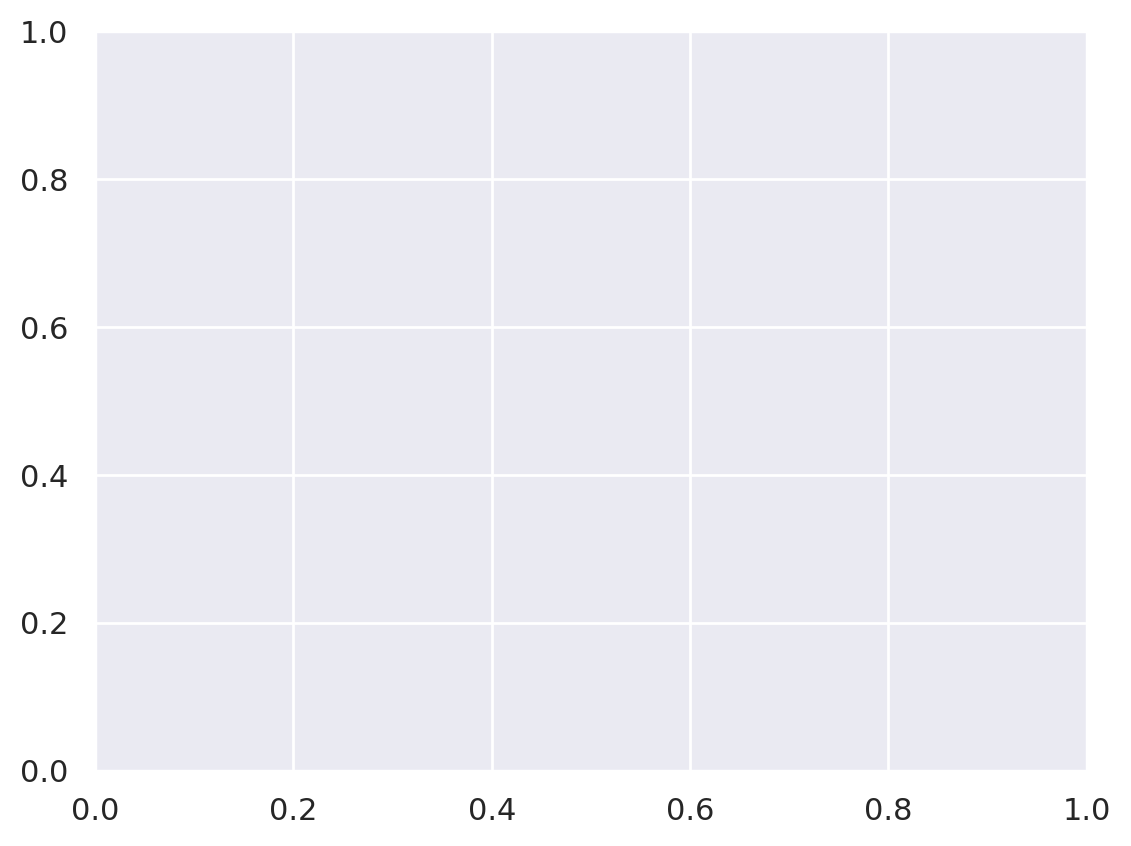

In [170]:
nx.draw_networkx(G, central_pos, node_size = snapshot.y)

0
1
2
3
4
5
6
7


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

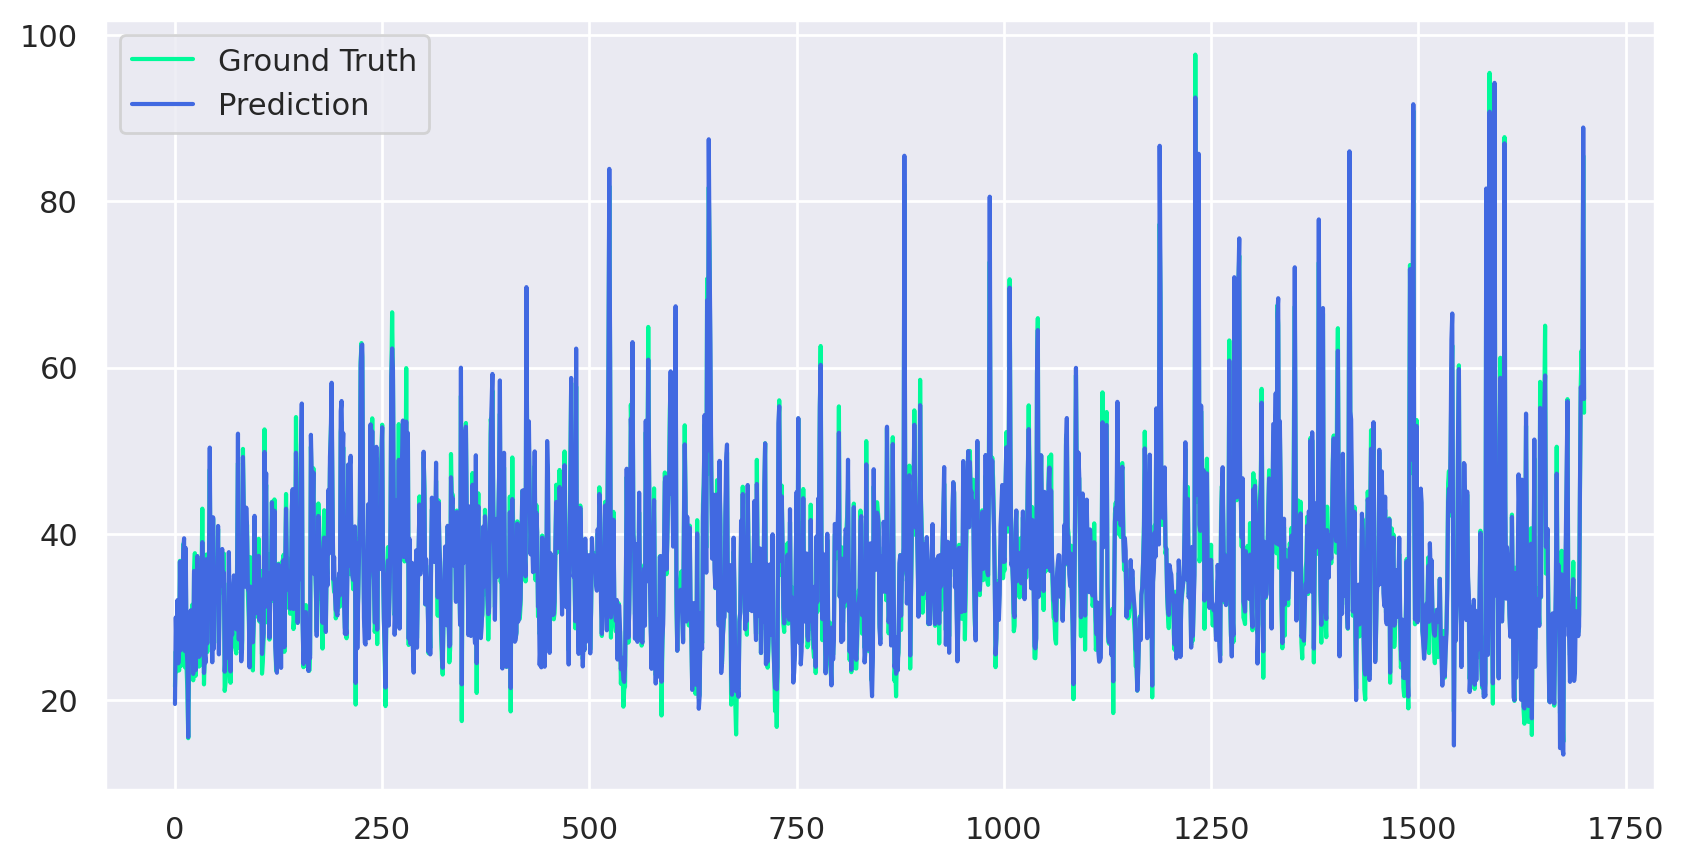

In [171]:
plt.figure(figsize=(10, 5))
# plt.plot((snapshot.x.t()[2].detach().cpu().reshape(-1,1))[:4500, :], label = "Ground Truth", color = "red")

plt.plot(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1))[:4500, :], label = "Ground Truth", color = "mediumspringgreen")
plt.plot(scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))[:4500, :], label = "Prediction", color = "royalblue")
# plt.plot((snapshot.x.t()[2].detach().cpu().reshape(-1,1))[:4500, :], label = "Ground Truth", color = "red")

plt.legend()

In [172]:
snapshot.x

tensor([[74.7500, 16.7500, 21.6504],
        [75.0000, 16.7500, 25.8869],
        [75.2500, 16.7500, 23.4728],
        ...,
        [85.7500, 26.2500, 58.4214],
        [86.0000, 26.2500, 85.4849],
        [86.2500, 26.2500, 54.5718]], device='cuda:0')

In [173]:
from sklearn.metrics import mean_squared_error
mean_squared_error(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)), scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1)))**0.5

1.7343291696965135

In [174]:
snapshot.x.t()[1].min()

tensor(16.7500, device='cuda:0')